### Project Implementation Introduction

<p>
    Introductory Paragraph
</p>

In [1]:
# Python libraries used retrieve dataset path information and time module to estimate model running time
import os
import time
import warnings

# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

# Python libraries used import dataset as a dataframe into the IDE, perform array manipulations
# and data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Python libraries used to preprocess dataset i.e. split the dataset into training set and testing set and also
# to standardize the dataset (optimize the dataset)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

# Supervised Learning models (Classifiers) used to implement the models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics used to analyze the performance of the implemented models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score

# SMOTE technique used to eliminate the imbalance in the dataset
from imblearn.over_sampling import SMOTE

# tensorflow keras Library used to implement the Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# import kerastunner as kt

# Evaluation Metrics used to analyze the performance of the ANN
from tensorflow.keras.metrics import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML as Center

Center(""" 
    <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
    </style> 
""")

#### Variable Delaration

In [2]:
# setting to enable IDE and pandas to display up 200 records at a time for data records less than 200 records
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 200
pd.options.display.max_rows = 200

# the processed dataset for analysis will be store in this dictionary
analysis_df_dict = dict()

# All result from the analysis will be store in this dictionary 
analysis_results = dict()

# The dependent variable attribute is store in this variable
target_variable = 'traffic_type'

# Implemented model name keys
NBC = "NBC"
SVM = "SVM"
DTC = "DTC"
RFC = "RFC"
ANN = "ANN"

# dataset label keys
kddcup99 = "kddcup99"
unswnb15 = "unswnb15"

# Analysis dataset name dictionary
dataset_label_dict = {
    kddcup99: "KDD CUPP 99",
    unswnb15: "UNSW NB15"
}

# Implemented model name dictionary
model_label_dict = {
    NBC: "NAIVE BAYES CLASSIFIER",
    SVM: "SUPPORT VECTOR MACHINE",
    DTC: "DECISION TREE CLASSIFIER",
    RFC: "RANDOM FOREST CLASSIFIER",
    ANN: "ARTIFICIAL NEURAL NETWORK",
}

# Evaluation Metrics labels
AUC = "AUC"
GMEAN = "G-MEAN"

# these are the key for starting the training and test dataset in the analysis_df_dict dictionary variable
x_train_key = "x_train"
x_test_key = "x_test"
y_train_key = "y_train"
y_test_key = "y_test"


### Implemented Objects Declaration

In [3]:
# This class is used to create an instance of artificial neural network (ANN). it uses tensorflow keras Sequential modules to build
# the model and uses tensorflow keras layer Dense Module to create the input layer, the hidden layer and the output layer.
# The KerasClassifier module is the wrapper that allow the use of sklearn GridSearchCV module to perform hyper-parameter 
# tuning

class ArtificailNeuralNetworkClassifier:
    __loss = None
    __optimizer = None
    __metrics = list()
    __epochs = None
    __batch_size  = None
    __input_dim = None
    __relu = "relu"
    __sigmoid="sigmoid"
    __softmax="softmax"
    __kernel_initializer="random_uniform"
    
    # Constructor function
    def __init__(self, input_dim, loss, optimizer, metrics, epochs = 10, batch_size=100):
        self.__loss = loss
        self.__optimizer = optimizer
        self.__metrics = metrics
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__input_dim = input_dim
    
    # neural network model build function
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.__input_dim, input_dim=self.__input_dim, activation=self.__relu, kernel_initializer=self.__kernel_initializer))
        model.add(Dense(1,activation=self.__sigmoid,kernel_initializer=self.__kernel_initializer))
        model.add(Dense(2,activation=self.__softmax))    
        model.compile(
            loss = self.__loss,
            optimizer = self.__optimizer,
            metrics = self.__metrics
        )
        model.summary()
        return model
    
    # build and compile the ANN model and wrapped using KerasClassifier module
    def get_model(self):
        return KerasClassifier(lambda: self.build_model(), epochs=self.__epochs, batch_size=self.__batch_size)

#### Reusable Function Declaration

In [4]:
# This function is used to plot pie charting showing the class distribution by class in percentage(%) 
# in the dependent variable

def show_pie_chart_target_variable(df, labels, colors, title):
    class_counts = [df[target_variable].value_counts()[0], df[target_variable].value_counts()[1]]
    count = df[target_variable].value_counts().to_frame().sort_index()
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=[colors[c] for c in count.index])
    plt.suptitle(title)
    plt.show()
    
    

In [5]:
# This function is used to plot bar charting showing the class distribution by class  using frequency count 
# in the dependent variable

def show_bar_chart_target_variable(df, target, labels, colors, title):
    ax = sns.countplot(x=target, data=df, palette=colors)
    ax.bar_label(container=ax.containers[0], labels=labels)
    ax.set(title=title)
    
    

In [6]:
# This is used to remove punctuation mark in the found to have been appended to the dataset dependent variable
# values

def remove_punctuation_from_value(x):
    return x.split('.')[0]



In [7]:
# This function is used to split the features as categorical variable and continuous variables. The concept here is that
# features with pandas' object datatype and integer with less than 10 unique different value were label categorical 
# variables. The rest features that was not in previous category was label are market as continuous variable and this 
# return a tuple

def split_dataframe_into_continuious_categorical_column_names(df):
    
    categorical_column_names = list(set(df.select_dtypes("object").columns))
    numeric_column_names = list(set(df.select_dtypes("number").columns))
    
    categorical_column_names = categorical_column_names if isinstance(categorical_column_names, list) else []
    continuous_column_names = list()
    
    for column_name in numeric_column_names:
        value_count = df[column_name].nunique()
        if value_count < 10:
            categorical_column_names.append(column_name)
        else:
            continuous_column_names.append(column_name)
        
    return categorical_column_names, continuous_column_names


In [8]:
# This function is used to retrieve the features names of column whose datatype is of the object(string) datatype

def get_object_data_type_column_names(df):
    categorical_cols = df.select_dtypes("object").columns
    return categorical_cols



In [9]:
# This function is used to retrieve the features names of column whose datatype is of the float64 datatype

def get_continuous_feature(df, feature_column_list):
    features = list()
    for feature in feature_column_list:
        if df[feature].dtype == 'float64':
            features.append(feature)
            
    return features


In [10]:
# This function is used to show bar charts for all categorical variables. The function also show the summary for the count of 
# the different unique values in the varaible

def show_bar_plots_for_all_categorical_plots(df, feature_column_list):
    
    fig, axes = plt.subplots(len(feature_column_list), 1,tight_layout=False)
    
    print()
    print()
    print()
    for ax, feature in zip(axes, feature_column_list):
        print("Summary for {} feature value counts".format(feature.upper()))
        print()
        print(df[feature].value_counts())
        print()
        print()
        print()
        title = "This is title for {} bar chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="bar")
        ax.set(title=title)
        
    plt.show()    
    

In [11]:
# This function is used to show histogram chart for all continuous variables.

def show_histogram_plots_for_all_continuous_plots(df, feature_column_list):
    
    feature_columns = get_continuous_feature(df, feature_column_list)
    fig, axes = plt.subplots(len(feature_columns), 1,tight_layout=False)
    
    for ax, feature in zip(axes, feature_columns):
        title = "This is title for {} histogram chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="hist")
        ax.set(title=title)
        
    plt.show()
    

In [12]:
# This function is used to perform feature mapping which help convert string datatype or pandas object datatype to integer
# datastype for columns having the object datatype. This function also invokes the generate_pmap_values() function to
# map the string values to integer values

def process_feature_mapping(df):
    object_column_names = get_object_data_type_column_names(df)
    
    print()
    print()
    print()
    print("FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME")
    print()
    for column_name in object_column_names:
        print("Processing feature mapping for {} feature".format(column_name))
        unique_values = df[column_name].unique()
        pmap_values = generate_pmap_values(unique_values)
        df[column_name] = df[column_name].map(pmap_values)
        print()
        print()
        
    return df


In [13]:
# This function is used generate key value pair dictionary data structure, assigning a value incremented by 1 to the list 
# of string values using a for loop. The initial value for the first item of the list is 0

def generate_pmap_values(unique_values):
    pmap = {}
    initial_value = 0
    
    for val in unique_values:
        pmap[val] = initial_value
        initial_value += 1
    
    return pmap


In [14]:
# This function is used to perform model analysis for the Naive Bayes supervised learning algorithm for experiment one.
# The function create an instance of the GaussianNB module and proceed to call the perform_model_analysis function to 
# train and make prediction using Naive Bayes model.

def perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = NBC
        model = GaussianNB()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [15]:
# This function is used to perform model analysis for the Support Vector Machine (SVM) supervised learning algorithm 
# for experiment one. The function create an instance of the SVC module and proceed to call the perform_model_analysis  
# function to train and make prediction using SVM model.

def perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = SVM
        model = svm.SVC(gamma = 'scale')
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [16]:
# This function is used to perform model analysis for the Decision Tree supervised learning algorithm 
# for experiment one. The function create an instance of the DecisionTreeClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Decision Tree model.

def perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = DTC
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [17]:
# This function is used to perform model analysis for the Random Forest supervised learning algorithm 
# for experiment one. The function create an instance of the RandomForestClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Random Forest model.

def perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = RFC
        model = RandomForestClassifier(n_estimators=30)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [18]:
# This function is used to perform model analysis for the Artificial Neural Network (ANN) which is a deep learning 
# algorithm for experiment one. The function create an instance of the ArtificailNeuralNetworkClassifier that we created and proceed  
# to call the perform_model_analysis function to train and make prediction using ANN model.


def perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = ANN
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', ['accuracy'])
        model = ann.get_model()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [19]:
# This function is use to perform model analysis and show summary for the model analysis and the function is invoked by all
# model analysing function created above. This function help to train the model by calling the fit method on the model 
# instance, then use the trained model to make predictions which is then used to analyse and display the summary of the
# model performance

def perform_model_analysis(model, analysis_df_dict, dataset_key, model_name):
    training_start_time = time.time()
    model.fit(analysis_df_dict[dataset_key][x_train_key], analysis_df_dict[dataset_key][y_train_key].values.ravel())
    training_end_time = time.time() 
        
    testing_start_time = time.time()
    model_preditions = model.predict(analysis_df_dict[dataset_key][x_test_key])
    testing_end_time = time.time()
    
    print()
    print()
    print("ANALYSIS SUMMARY FOR {} MODEL FOR {} DATASET".format(model_label_dict[model_name], dataset_label_dict[dataset_key]))
    print()
    print()
    
    print()
    print()
    print()
    print("TRAINING TIME")
    print("=========================================================")
    print()
    print("{:.2f}".format(training_end_time - training_start_time))
    print()
    print()
    print()
    
    
    print()
    print()
    print()
    print("TESTING TIME")
    print("=========================================================")
    print()
    print("{:.2f}".format(testing_end_time - testing_start_time))
    print()
    print()
    print()
    
    print("CLASSIFICTION REPORT")
    print("=========================================================")
    print()
    print(classification_report(model_preditions, analysis_df_dict[dataset_key][y_test_key], target_names=["Normal", "Attack"]))
    
    
    print()
    print()
    print()
    print("CONFUSION MATRIX")
    print("=========================================================")
    print()
    conf_mat = confusion_matrix(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    plt.figure(figsize=(5,5))
    ax_plot = sns.heatmap(conf_mat, annot=True)
    ax_plot.set_title("Seaborn Confusion Matrix Plot")
    ax_plot.set_xlabel('Predicted Values')
    ax_plot.set_ylabel('Actual Values')
    ax_plot.xaxis.set_ticklabels(["FALSE", "TRUE"])
    ax_plot.yaxis.set_ticklabels(["NEGATIVE", "POSITVE"])
    plt.show()
    
    
    print()
    print()
    print()
    print("MODEL PERFORMANCE EVALUATION")
    print("=========================================================")
    print()
    auc_score = roc_auc_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    gmean_score = geometric_mean_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    print("AUC SCORE:  {:.4f}".format(auc_score))
    print("GEOMETRIC MEAN SCORE:  {:.4f}".format(gmean_score))
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    
    result = {
        AUC: auc_score,
        GMEAN: gmean_score
    }
    
    return result
    

In [25]:
# This function is used to plot the correlation  heatmap for a selected group of features from the dataset

def show_correlation_heatmap_chart(df, title):
    df = df[[col for col in df if df[col].nunique() > 1]]
    corr = df.corr()
    plt.figure(figsize=(18,20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, cmap=plt.cm.Reds, annot=True, mask=mask, linewidths=0.5, annot_kws={ "size": 10 })
    sns.set_style("white")
    plt.suptitle(title)
    plt.show()

In [ ]:
# This function estimate the correlation between features the in a given dataset and select feature with high correlation.
# The correlation is said to be high if it is greater than the threshold argument given function. The function print out
# features with high correlation and the estimated value while returning a list of features name that has been marked 
# high

def estimate_correlation_to_select_highly_correlated_features(df, threshold):
    column_names = set()
    highly_corr_feature = dict()
    correlation_matrix = df.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            computed_corr = correlation_matrix.iloc[i,j]
            if computed_corr > threshold:
                column_name = correlation_matrix.columns[i]
                column_names.add(column_name)
                highly_corr_feature[column_name] = computed_corr


    print()
    print()
    print()
    print("FEATURES WITH HIGH CORRELATION VALUES")
    print("===================================================")
    for key in highly_corr_feature.keys():
        print()
        print("{}: {}".format(key, highly_corr_feature[key]))
        print()

    print()
    print()
    print()
    print()
    print()
    print()
    return list(column_names)

In [ ]:
def use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    start_time = time.time()
    
    if cv == None:
        model = RandomizedSearchCV(model, param_grid)
    else:
        model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 5, n_jobs = -1)
    
    end_time = time.time()
    PRINT()
    PRINT()
    print("HYPER PARAMETER TUNING FOR {} TO ANALYZE {} DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS {:.3f} SECONDS".format(model_label_dict[model_name], dataset_label_dict[dataset_name], end_time-start_time))
    PRINT()
    PRINT()
    PRINT()
    return model


In [ ]:
def use_GridSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    start_time = time.time()
    
    if cv == None:
        model = GridSearchCV(model, param_grid)
    else:
        model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
        
    end_time = time.time()
    PRINT()
    PRINT()
    print("HYPER PARAMETER TUNING FOR {} TO ANALYZE {} DATASET USING GridSearchCV. TIME TAKEN TO SELECT PARAMETERS IS {:.3f} SECONDS".format(model_label_dict[model_name], dataset_label_dict[dataset_name], end_time-start_time))
    PRINT()
    PRINT()
    PRINT()
    return model
    

In [ ]:
def hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = NBC
        param_grid = {
            "var_smoothing": np.logspace(0,-9, num=100)
        }
        model = GaussianNB()
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)

        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [ ]:
def hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = SVM
        tuned_parameters = {'kernel': ['linear', 'rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 50]}
        model = svm.SVC()
        # model = use_GridSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [ ]:
def hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = DTC
        param_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": range(1, 10),
            "min_samples_split": range(1, 10),
            "min_samples_leaf": range(1, 5)
        }
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [ ]:
def hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = RFC
        param_grid = { 
            'n_estimators': [20, 50, 100],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [80, 90, 100],
            'criterion' :['gini', 'entropy'],
            'bootstrap': [True],
        }
        model = RandomForestClassifier(n_estimators=30)
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [ ]:
def hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = ANN
        batch_size = [20, 50, 100]
        epochs = [10, 50, 100]
        param_grid = dict(batch_size=batch_size, epochs=epochs)
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', [ "accuracy" ])
        model = ann.get_model()
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

#### Import Dataset into IDE

In [ ]:
dataset_directory_path = "/data/project/"
kdd_cup_filename = "kddcup.data.corrected"

unsw_nb15_filename1 = "UNSW_NB15_training-set.csv"
unsw_nb15_filename2 = "UNSW_NB15_testing-set.csv"


kdd_cup_df = None
unsw_nb15_df = None

kdd_cup_column_header =(['duration','protocol_type','service','flag','src_bytes','dst_bytes',
                         'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                         'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                         'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                         'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                         'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',target_variable])

try:
    # Load dataset into IDE from file
    kdd_cup_df = pd.read_csv(os.getcwd() + dataset_directory_path + kdd_cup_filename)
    
    # Attach column header to dataframe
    kdd_cup_df.columns = kdd_cup_column_header
    
    unsw_nb15_df1 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename1)
    unsw_nb15_df2 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename2)
    
    unsw_nb15_df = pd.concat([unsw_nb15_df1, unsw_nb15_df2], ignore_index=True)
    unsw_nb15_df.rename(columns={"label": target_variable}, inplace = True)
    
    kdd_cup_df = kdd_cup_df.sample(n=50000)
    unsw_nb15_df = unsw_nb15_df.sample(n=50000)
except NameError:
    kdd_cup_df = None
    unsw_nb15_df = None
    print("FATAL ERROR:  Dataset records could not be read into the IDE.")
    print("Error Response")
    print(NameError)
    exit()

#### Preprocesing and Dataset Cleaning

In [ ]:
kdd_cup_df.head(100)

In [ ]:
unsw_nb15_df.head(100)

In [ ]:
kdd_cup_df.shape

In [ ]:
unsw_nb15_df.shape

In [ ]:
kdd_cup_df.isnull().sum()

In [ ]:
unsw_nb15_df.isnull().sum()

In [ ]:
kdd_cup_df.info()

In [ ]:
unsw_nb15_df.info()

In [ ]:
# kdd_cup_df = kdd_cup_df.drop(['num_outbound_cmds'], axis=1)
unsw_nb15_df = unsw_nb15_df.drop(['attack_cat'], axis=1)

In [ ]:
kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: remove_punctuation_from_value(x))

#### Exploratory Data Analysis (EDA)

In [ ]:
eda_kdd_cup_df = kdd_cup_df
eda_unsw_nb15_df = unsw_nb15_df

eda_kdd_cup_df[target_variable] = eda_kdd_cup_df[target_variable].apply(lambda x: 0 if x.lower()=="normal" else 1)

In [ ]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_kdd_cup_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for KDD CUP 99 Dataset')

In [ ]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_kdd_cup_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart for KDD CUP 99 Dataset')

In [ ]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_unsw_nb15_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for UNSW-NB15 Dataset')

In [ ]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_unsw_nb15_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart')

In [ ]:
eda_kdd_cup_df = eda_kdd_cup_df.drop([target_variable], axis=1)
eda_unsw_nb15_df = eda_unsw_nb15_df.drop([target_variable], axis=1)

In [ ]:
eda_kdd_cup_99_categorical_features, eda_kdd_cup_99_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_kdd_cup_df)

In [ ]:
eda_unsw_nb15_categorical_features, eda_unsw_nb15_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_unsw_nb15_df)

In [ ]:
show_bar_plots_for_all_categorical_plots(eda_kdd_cup_df, eda_kdd_cup_99_categorical_features)

In [ ]:
show_bar_plots_for_all_categorical_plots(eda_unsw_nb15_df, eda_unsw_nb15_categorical_features)

In [ ]:
show_histogram_plots_for_all_continuous_plots(eda_kdd_cup_df, eda_kdd_cup_99_continuous_features)

In [ ]:
show_histogram_plots_for_all_continuous_plots(eda_unsw_nb15_df, eda_unsw_nb15_continuous_features)

#### Spliting and Standardizing Dataset for Experiment I

In [ ]:
target_kdd_cup_df = kdd_cup_df[target_variable]
target_unsw_nb15_df = unsw_nb15_df[target_variable]

In [21]:
features_kdd_cup_df = kdd_cup_df.drop([target_variable], axis=1)
features_unsw_nb15_df = unsw_nb15_df.drop([target_variable], axis=1)

NameError: name 'kdd_cup_df' is not defined

In [ ]:
features_kdd_cup_df = process_feature_mapping(features_kdd_cup_df)

In [ ]:
features_kdd_cup_df.head()

In [ ]:
features_unsw_nb15_df = process_feature_mapping(features_unsw_nb15_df)

In [22]:
features_unsw_nb15_df.head()

NameError: name 'features_unsw_nb15_df' is not defined

In [23]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

NameError: name 'features_kdd_cup_df' is not defined

In [24]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

NameError: name 'features_unsw_nb15_df' is not defined

In [58]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [59]:
ros = SMOTE()

kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)

unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)

In [60]:
print(kddcup_y_train.agg(['nunique','count','size']))
print()
print(kddcup_y_train[kddcup_y_train == 0].count())
print()
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      63908
size       63908
Name: traffic_type, dtype: int64

31954

31954


In [61]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      51116
size       51116
Name: traffic_type, dtype: int64

25558

25558


In [62]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment I

In [63]:
experiment_type = "EXPERIMENT-ONE"



ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.86      0.97      0.91      1774
      Attack       0.99      0.97      0.98      8226

    accuracy                           0.97     10000
   macro avg       0.93      0.97      0.95     10000
weighted avg       0.97      0.97      0.97     10000




CONFUSION MATRIX



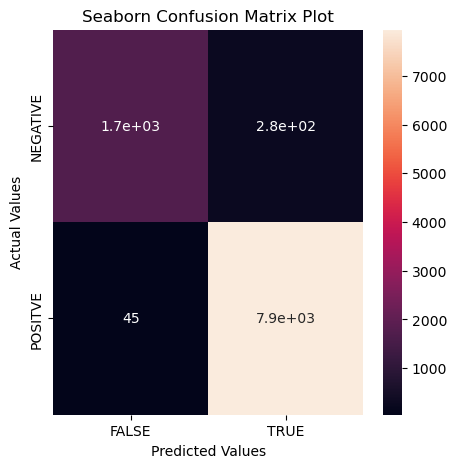




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9279
GEOMETRIC MEAN SCORE:  0.9255










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.88      0.65      0.75      4924
      Attack       0.73      0.91      0.81      5076

    accuracy                           0.78     10000
   macro avg       0.80      0.78      0.78     10000
weighted avg       0.80      0.78      0.78     10000




CONFUSION MATRIX



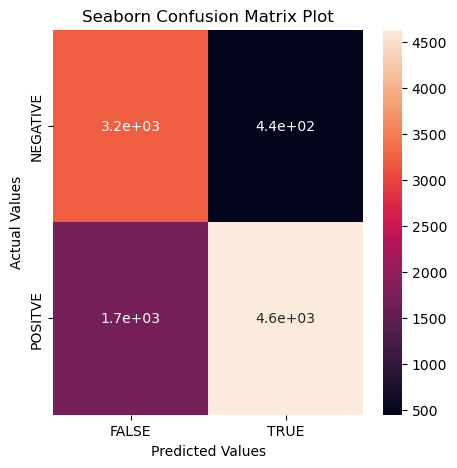




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8045
GEOMETRIC MEAN SCORE:  0.8011










In [64]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      2018
      Attack       1.00      1.00      1.00      7982

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



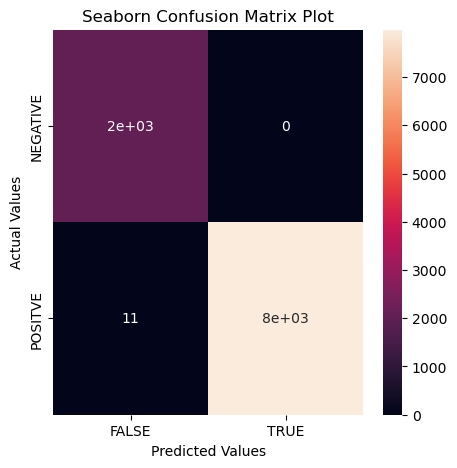




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9993
GEOMETRIC MEAN SCORE:  0.9993










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.95      0.83      0.88      4197
      Attack       0.88      0.97      0.92      5803

    accuracy                           0.91     10000
   macro avg       0.92      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000




CONFUSION MATRIX



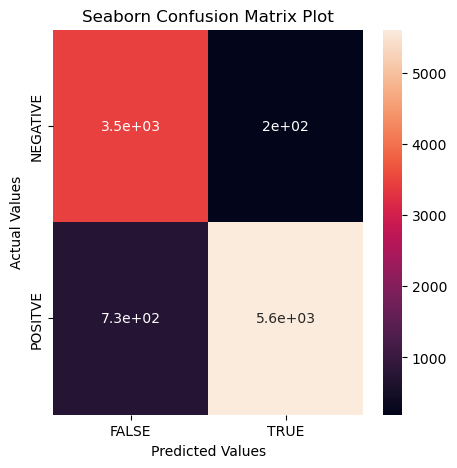




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9157
GEOMETRIC MEAN SCORE:  0.9152










In [65]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      2024
      Attack       1.00      1.00      1.00      7976

    accuracy                           1.00     10000
   macro avg       1.00      0.99      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



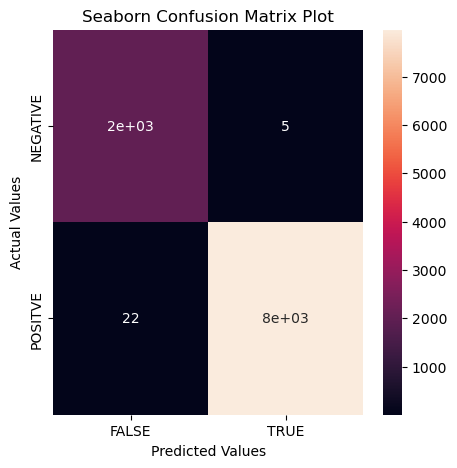




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9974
GEOMETRIC MEAN SCORE:  0.9974










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.96      0.73      0.83      4836
      Attack       0.79      0.97      0.87      5164

    accuracy                           0.86     10000
   macro avg       0.88      0.85      0.85     10000
weighted avg       0.88      0.86      0.85     10000




CONFUSION MATRIX



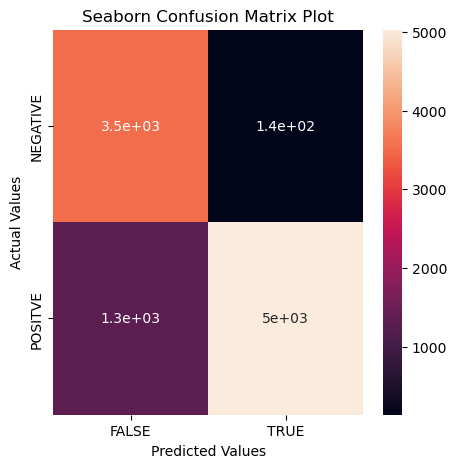




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8782
GEOMETRIC MEAN SCORE:  0.8741










In [66]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2009
      Attack       1.00      1.00      1.00      7991

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



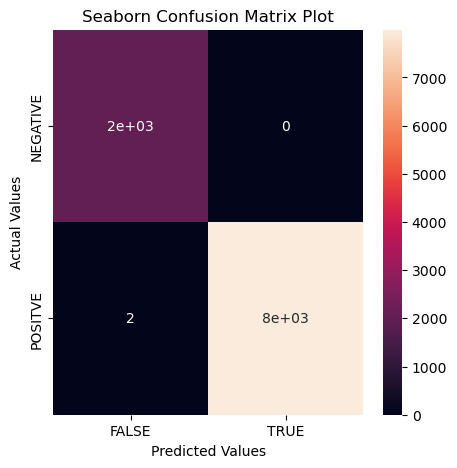




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9999
GEOMETRIC MEAN SCORE:  0.9999










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.92      0.93      0.92      3626
      Attack       0.96      0.95      0.95      6374

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000




CONFUSION MATRIX



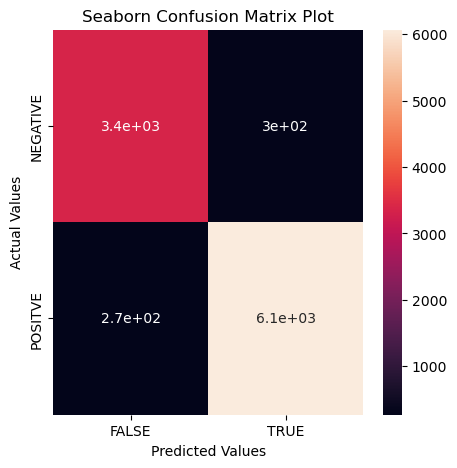




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9373
GEOMETRIC MEAN SCORE:  0.9370










In [67]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1722      
                                                                 
 dense_1 (Dense)             (None, 1)                 42        
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
640/640 [==============================] - 3s 3ms/step - loss: 0.4144 - accuracy: 0.9065
Epoch 2/10
640/640 [==============================] - 2s 3ms/step - loss: 0.2114 - accuracy: 0.9973
Epoch 3/10
640/640 [==============================] - 2s 3ms/step - loss: 0.1364 - accuracy: 0.9974
Epoch 4/10
640/640

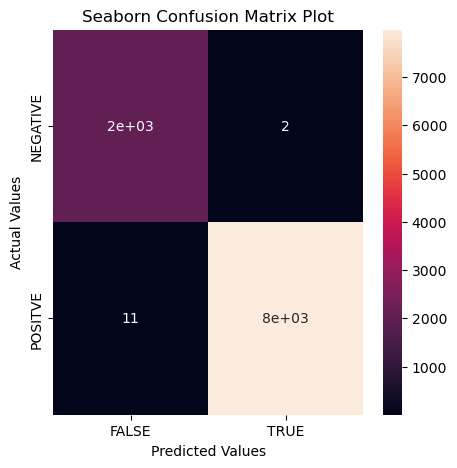




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9988
GEOMETRIC MEAN SCORE:  0.9988








Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 43)                1892      
                                                                 
 dense_4 (Dense)             (None, 1)                 44        
                                                                 
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
512/512 [==============================] - 3s 4ms/step - loss: 0.5902 - accuracy: 0.7692
Epoch 2/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4318 - accuracy: 0.8840
Epoch 3/10
512/512 [======

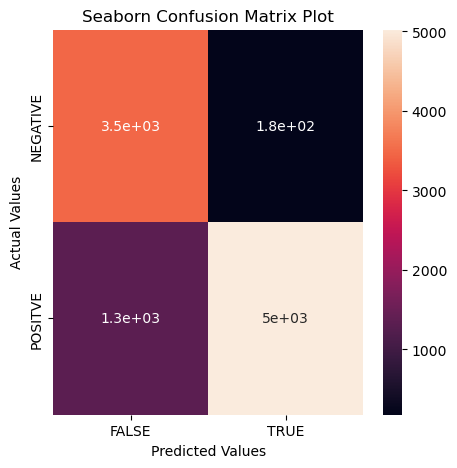




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8717
GEOMETRIC MEAN SCORE:  0.8680










In [68]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment I

In [69]:
KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [70]:
UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [71]:
KDD_Analysis_Summary_df

,AUC,G-MEAN
NBC,0.927927,0.925546
SVM,0.999312,0.999312
DTC,0.997378,0.997378
RFC,0.999875,0.999875
ANN,0.998814,0.998814


In [72]:
UNSWNB15_Analysis_Summary_df

,AUC,G-MEAN
NBC,0.804503,0.801097
SVM,0.915709,0.915183
DTC,0.878234,0.874121
RFC,0.937263,0.937044
ANN,0.871672,0.868046


### Experiment II Setup

#### Correlation Heatmap for the two datasets

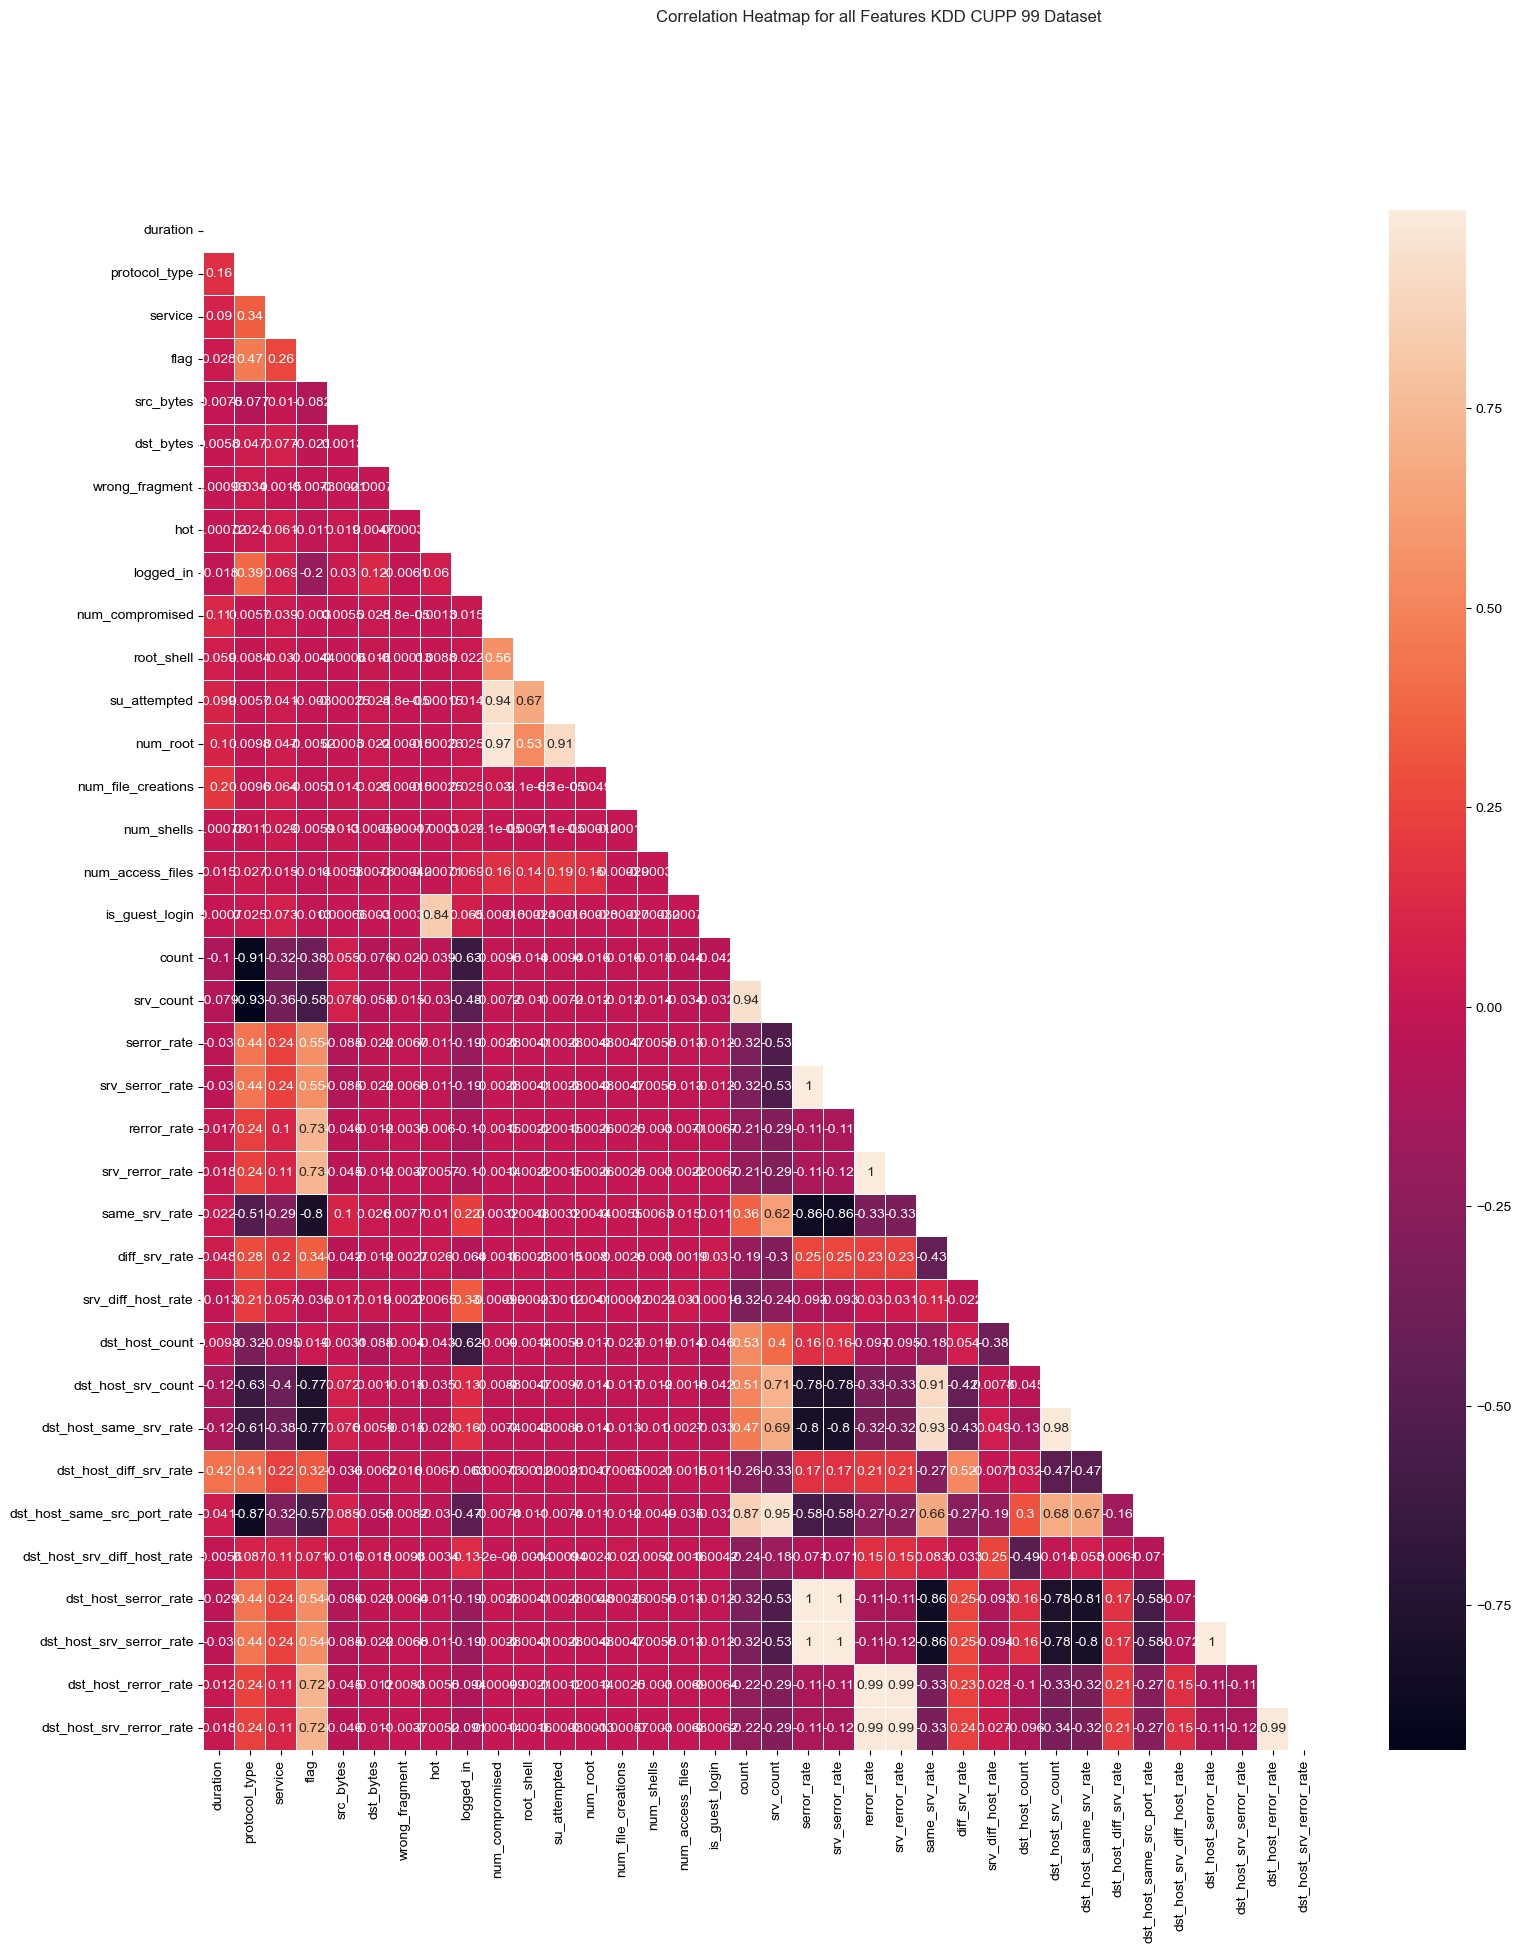

In [73]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

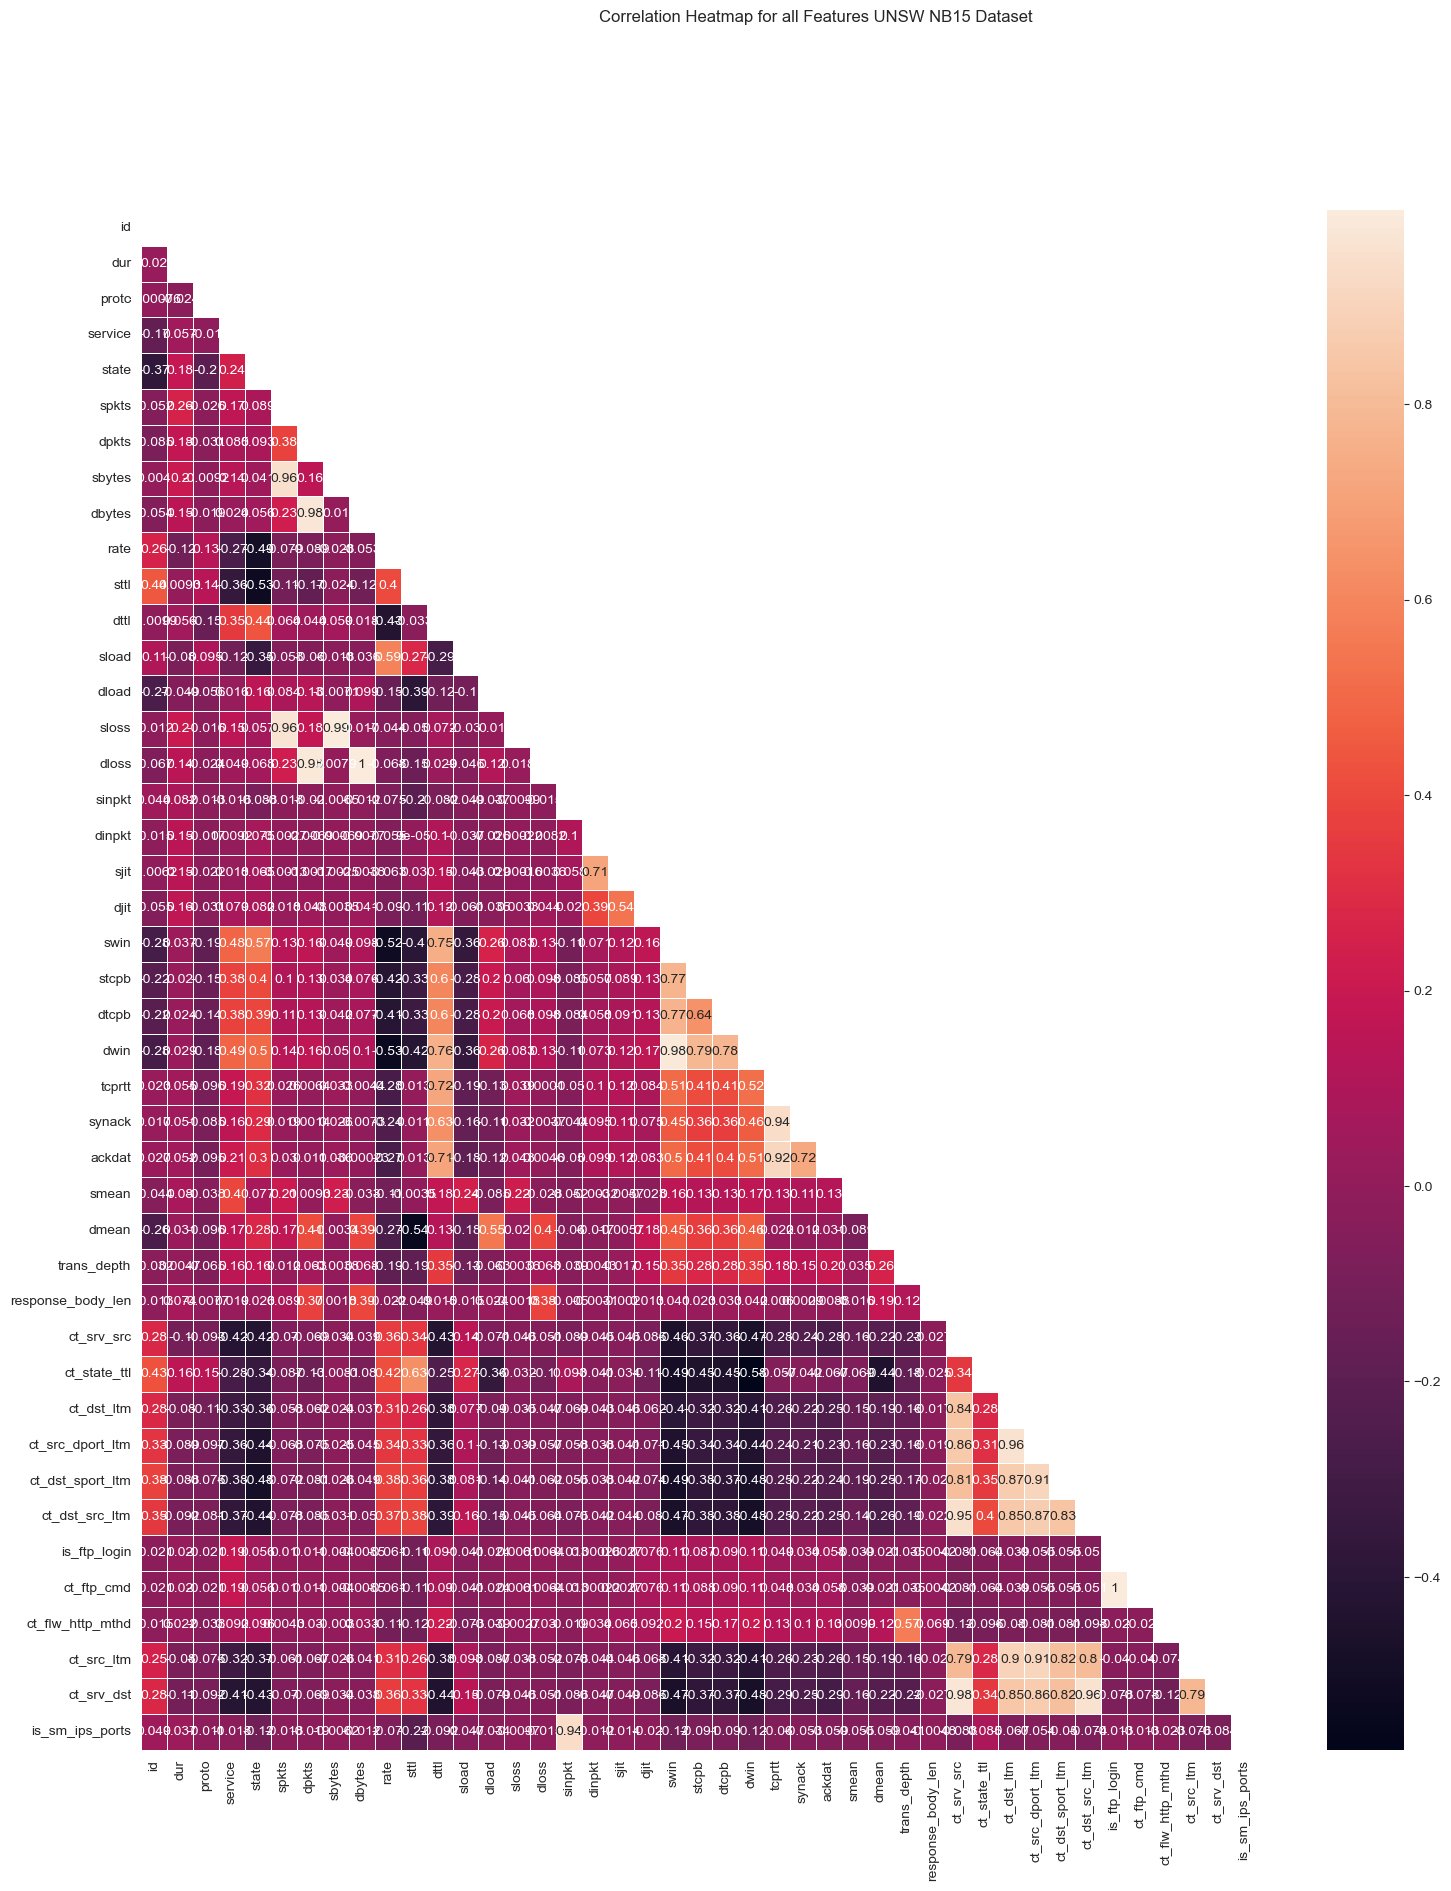

In [74]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [75]:
highly_correlation_kdd_cup_99_features = estimate_correlation_to_select_highly_correlated_features(features_kdd_cup_df, 0.90)




FEATURES WITH HIGH CORRELATION VALUES

su_attempted: 0.9390301845823356


num_root: 0.909785012385817


srv_count: 0.9449676490003162


srv_serror_rate: 0.9990856305868288


srv_rerror_rate: 0.995981153260987


dst_host_srv_count: 0.9106736925656709


dst_host_same_srv_rate: 0.9796411513945456


dst_host_same_src_port_rate: 0.9484078532204182


dst_host_serror_rate: 0.9978672504209031


dst_host_srv_serror_rate: 0.9985485189826224


dst_host_rerror_rate: 0.9881030205464533


dst_host_srv_rerror_rate: 0.9886545017184553









In [76]:
highly_correlation_unswnb15_features = estimate_correlation_to_select_highly_correlated_features(features_unsw_nb15_df, 0.90)




FEATURES WITH HIGH CORRELATION VALUES

sbytes: 0.9553293559997884


dbytes: 0.9789351115634563


sloss: 0.9948631049268745


dloss: 0.9969664267412287


dwin: 0.9808001670413957


synack: 0.9410013008351634


ackdat: 0.9151912250522108


ct_src_dport_ltm: 0.9599862601149667


ct_dst_sport_ltm: 0.9071381983227718


ct_dst_src_ltm: 0.953343237796626


ct_ftp_cmd: 0.9986183322650259


ct_src_ltm: 0.9096494376734996


ct_srv_dst: 0.9593405480388174


is_sm_ips_ports: 0.9403131291468108









In [77]:
highly_correlation_kdd_cup_99_features
features_kdd_cup_df.drop(highly_correlation_kdd_cup_99_features, axis=1,  inplace = True)

['dst_host_rerror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_count',
 'srv_count',
 'srv_serror_rate',
 'dst_host_srv_rerror_rate',
 'num_root',
 'dst_host_same_src_port_rate',
 'dst_host_same_srv_rate',
 'su_attempted',
 'srv_rerror_rate']

In [78]:
highly_correlation_unswnb15_features
features_unsw_nb15_df.drop(highly_correlation_unswnb15_features, axis=1,  inplace = True)

['dloss',
 'sloss',
 'ackdat',
 'dbytes',
 'synack',
 'ct_dst_src_ltm',
 'dwin',
 'ct_dst_sport_ltm',
 'ct_ftp_cmd',
 'ct_src_ltm',
 'is_sm_ips_ports',
 'ct_srv_dst',
 'ct_src_dport_ltm',
 'sbytes']

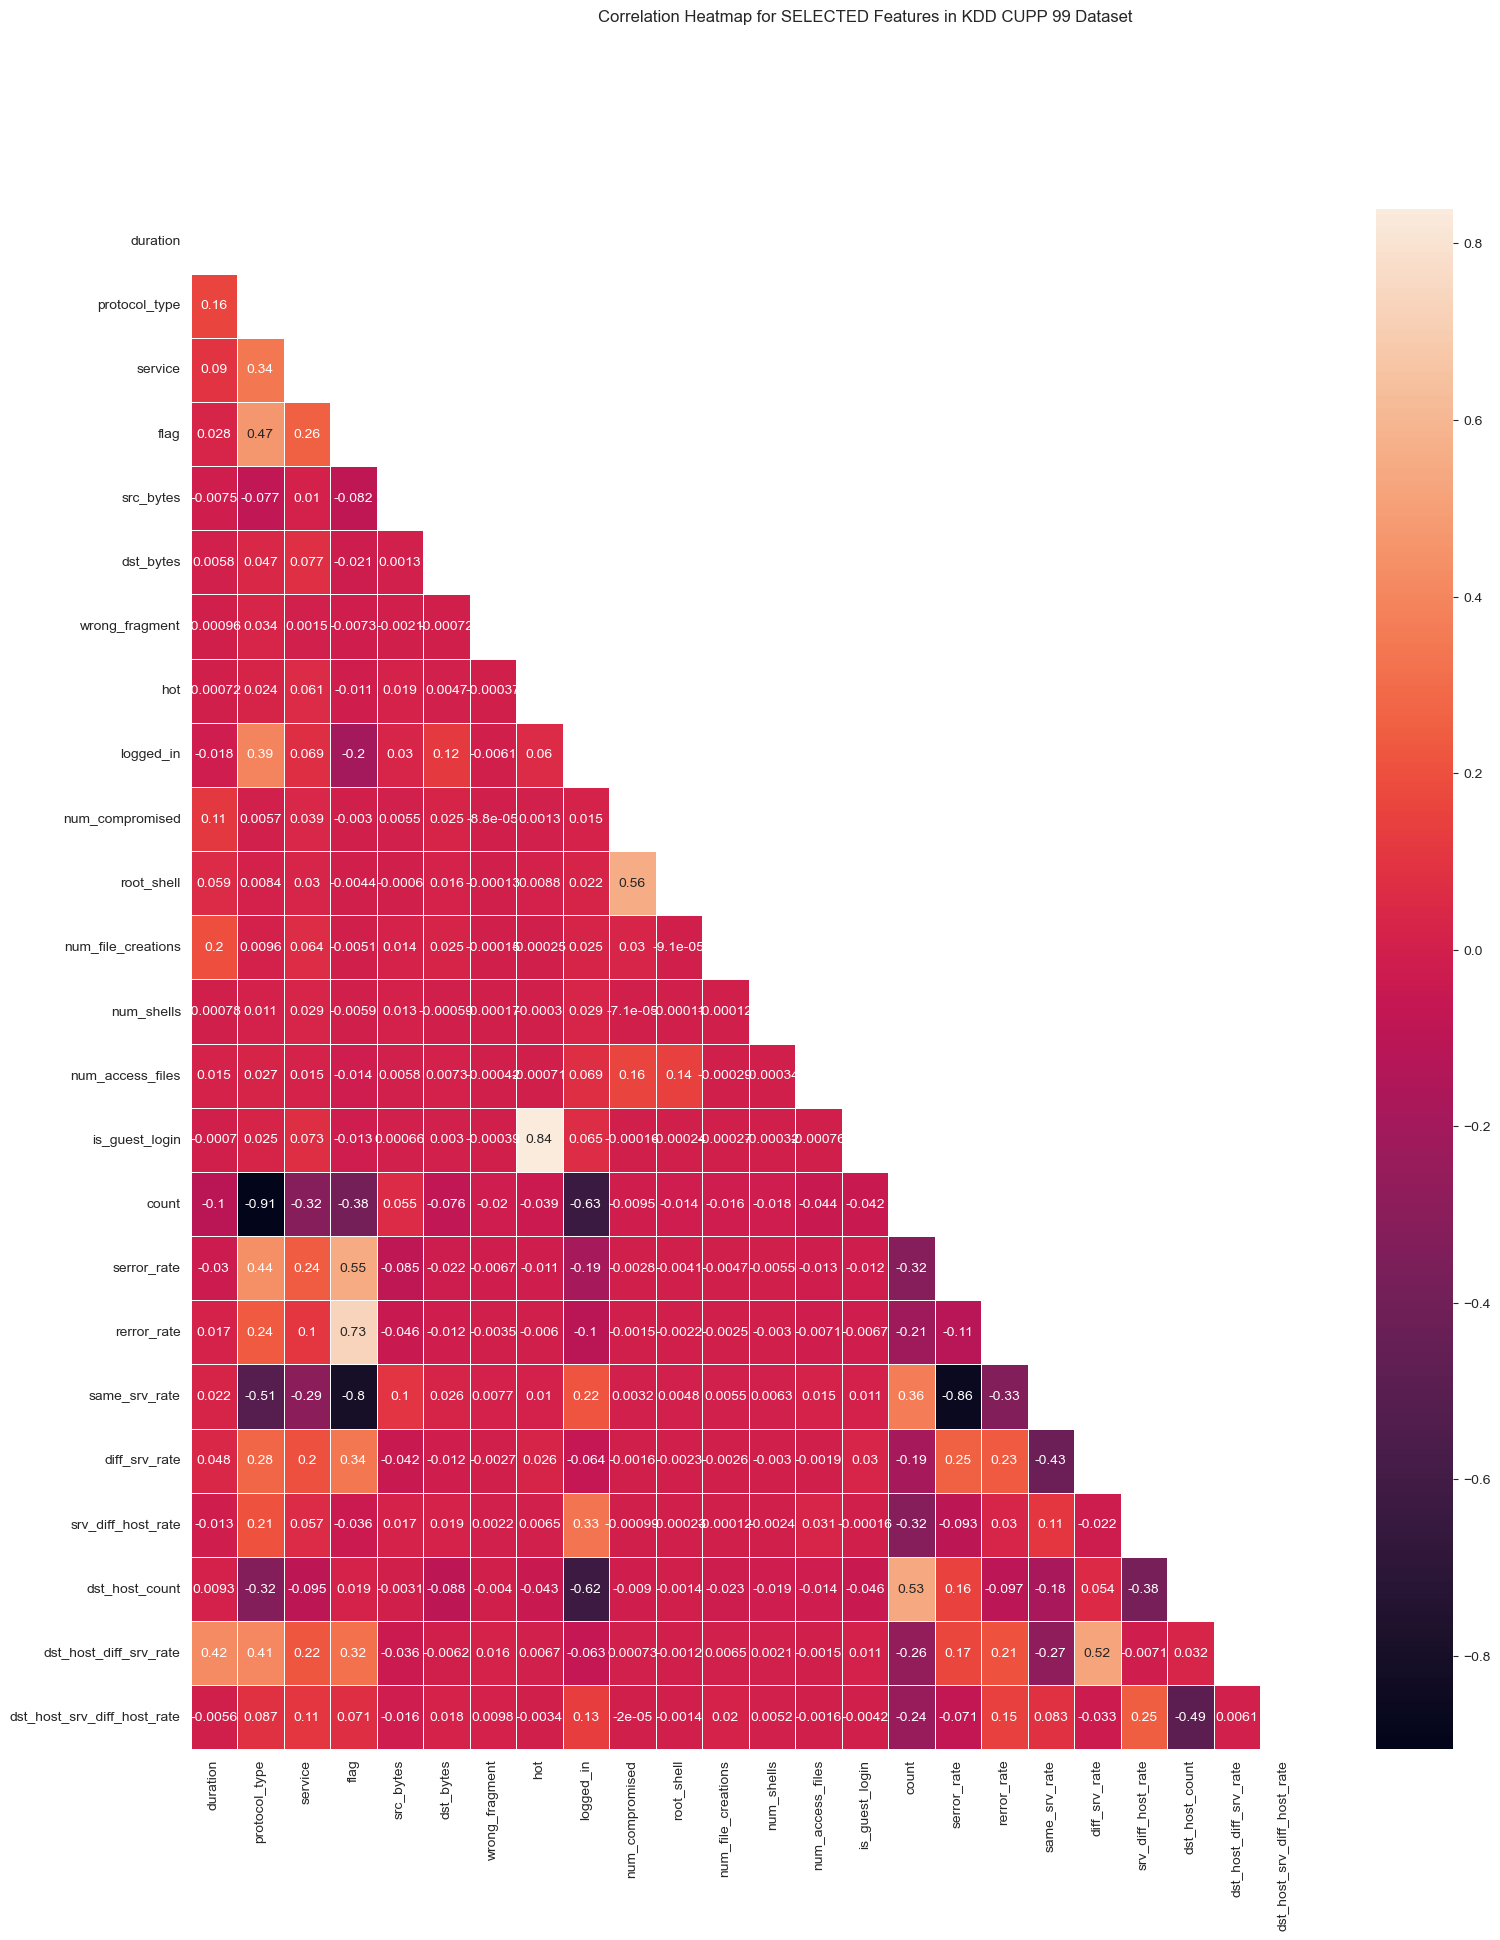

In [79]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

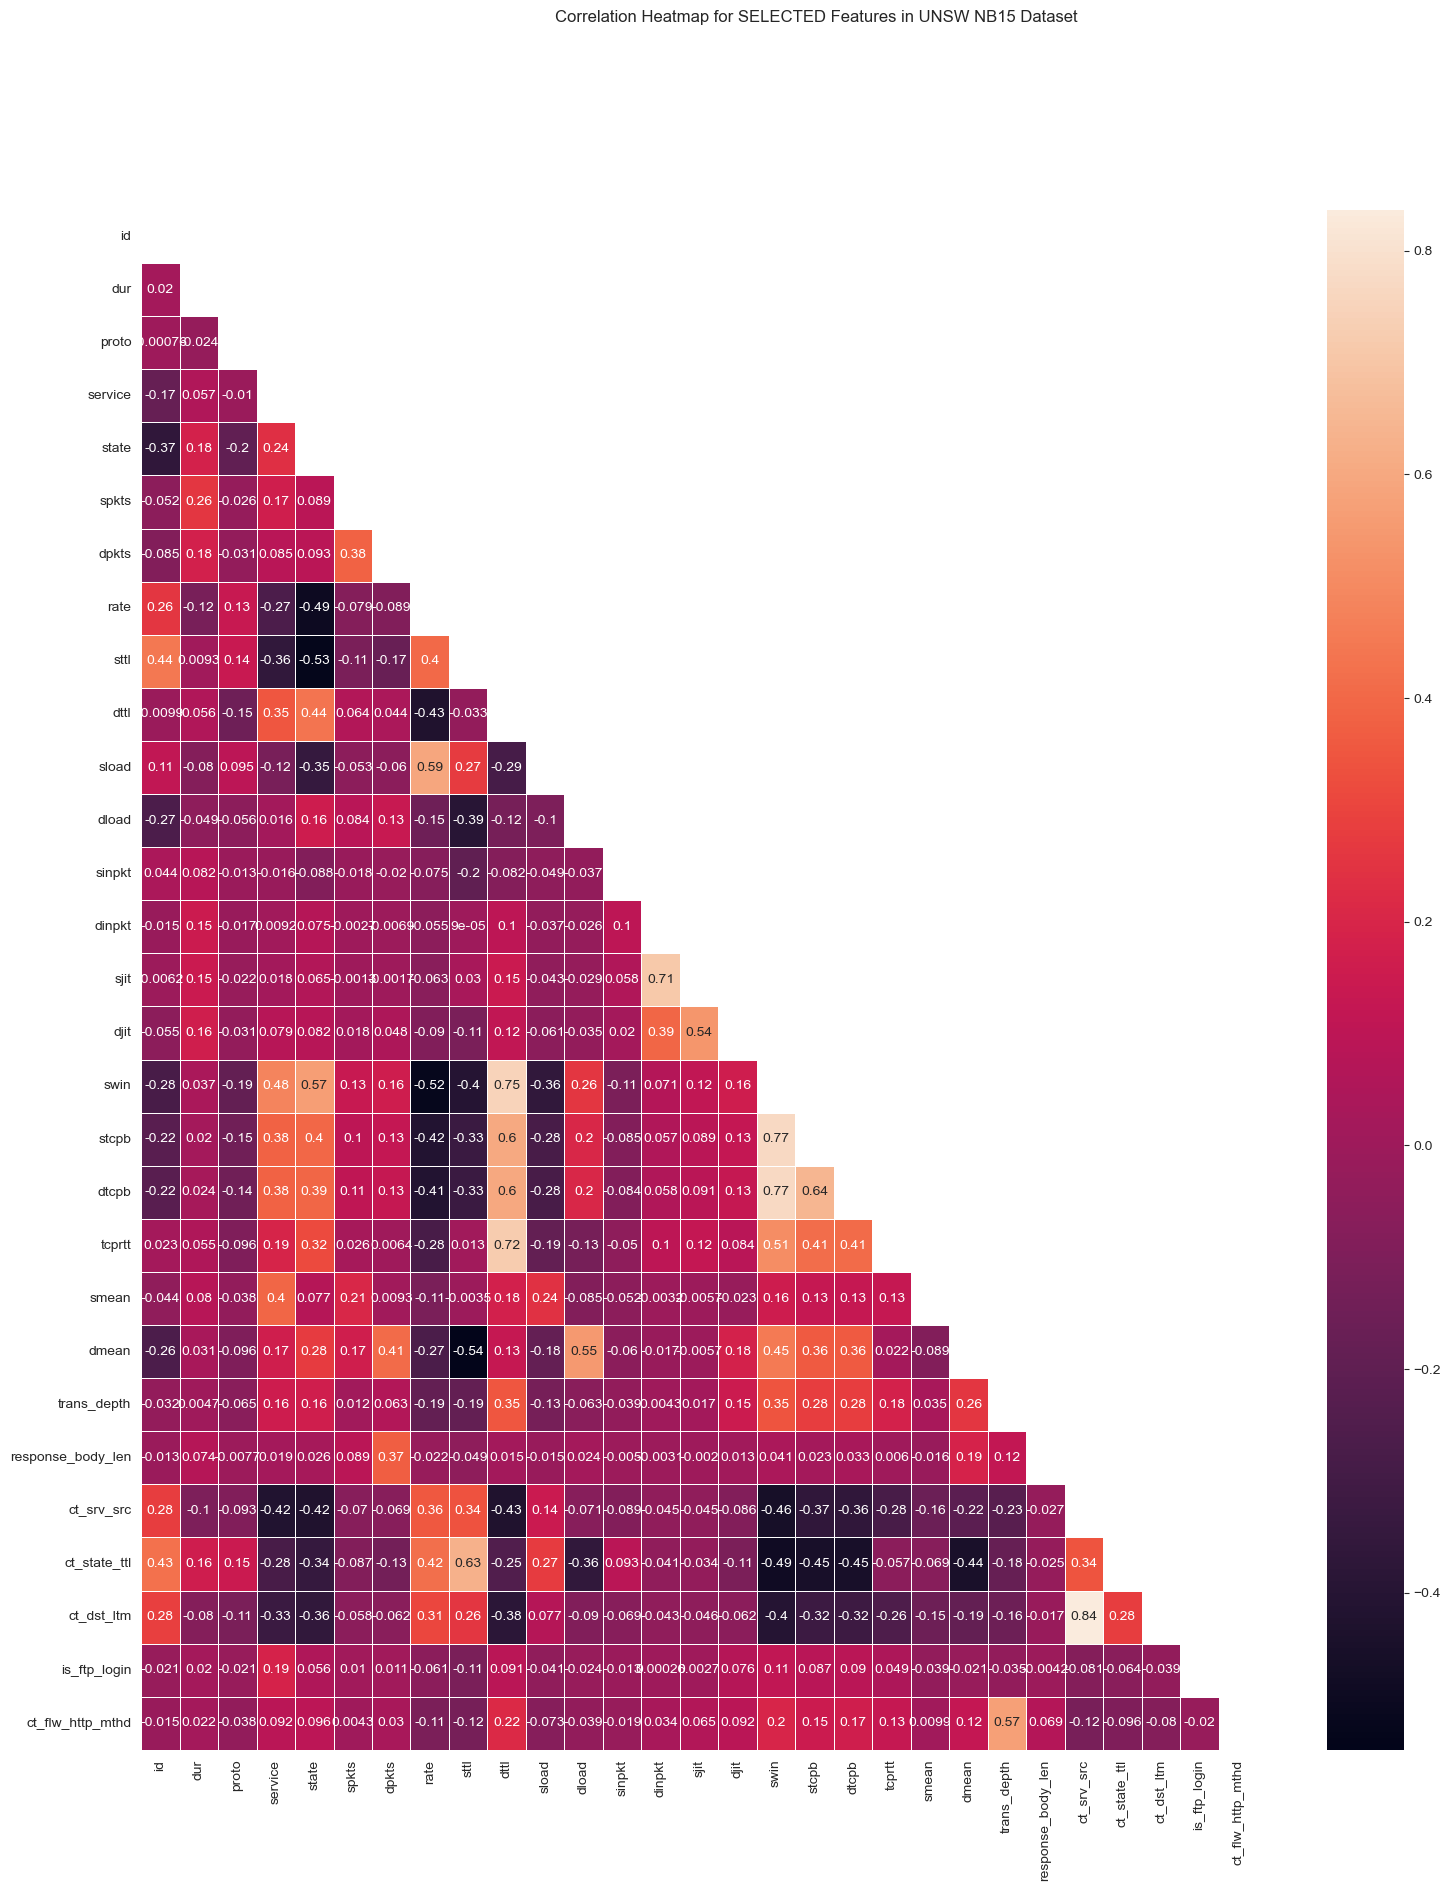

In [80]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [81]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [82]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [83]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [84]:
ros = SMOTE()

kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)

unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)

In [85]:
print(kddcup_y_train.agg(['nunique','count','size']))
print()
print(kddcup_y_train[kddcup_y_train == 0].count())
print()
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      63908
size       63908
Name: traffic_type, dtype: int64

31954

31954


In [86]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      51116
size       51116
Name: traffic_type, dtype: int64

25558

25558


In [87]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment II

In [88]:
experiment_type = "EXPERIMENT-TWO"



ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      2045
      Attack       0.99      1.00      1.00      7955

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.99     10000
weighted avg       0.99      0.99      0.99     10000




CONFUSION MATRIX



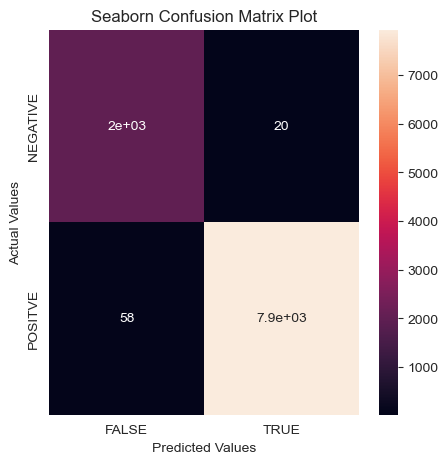




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9914
GEOMETRIC MEAN SCORE:  0.9914










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.89      0.68      0.77      4749
      Attack       0.76      0.92      0.83      5251

    accuracy                           0.81     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.81      0.80     10000




CONFUSION MATRIX



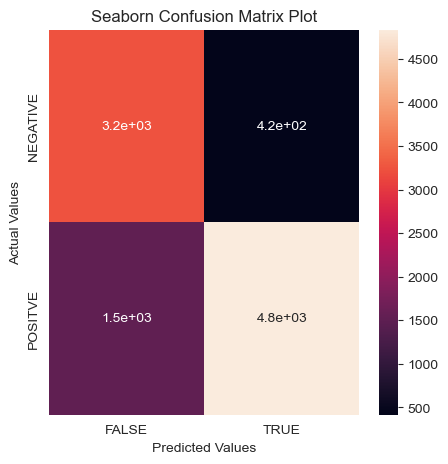




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8246
GEOMETRIC MEAN SCORE:  0.8222










In [89]:
hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      2021
      Attack       1.00      1.00      1.00      7979

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



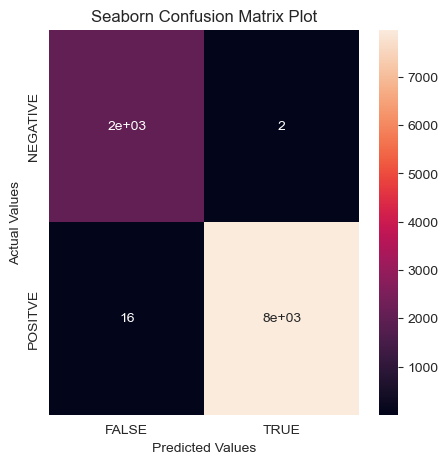




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9985
GEOMETRIC MEAN SCORE:  0.9985










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.93      0.75      0.83      4506
      Attack       0.82      0.95      0.88      5494

    accuracy                           0.86     10000
   macro avg       0.88      0.85      0.86     10000
weighted avg       0.87      0.86      0.86     10000




CONFUSION MATRIX



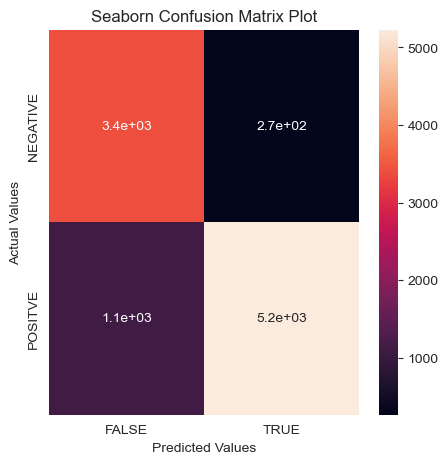




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8760
GEOMETRIC MEAN SCORE:  0.8745










In [90]:
hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98      1972
      Attack       1.00      0.99      1.00      8028

    accuracy                           0.99     10000
   macro avg       0.98      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000




CONFUSION MATRIX



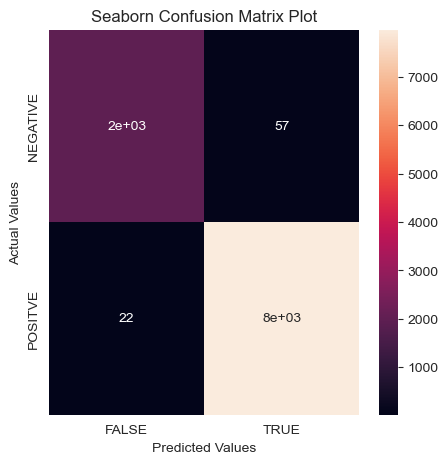




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9844
GEOMETRIC MEAN SCORE:  0.9843










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.96      0.92      0.94      3824
      Attack       0.95      0.98      0.96      6176

    accuracy                           0.95     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000




CONFUSION MATRIX



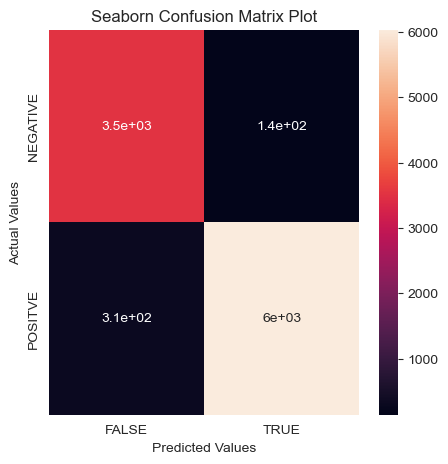




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9559
GEOMETRIC MEAN SCORE:  0.9559










In [91]:
hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2008
      Attack       1.00      1.00      1.00      7992

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



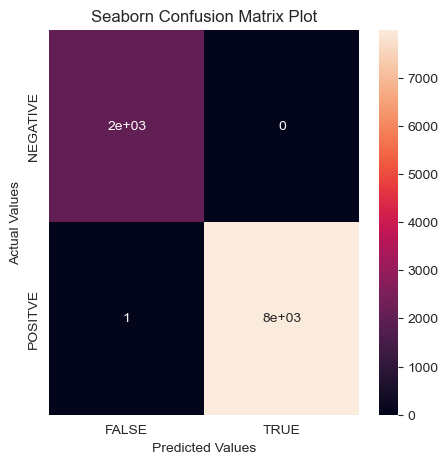




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9999
GEOMETRIC MEAN SCORE:  0.9999










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.93      0.93      0.93      3649
      Attack       0.96      0.96      0.96      6351

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000




CONFUSION MATRIX



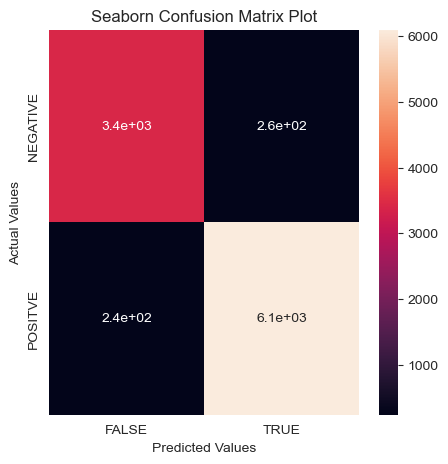




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9460
GEOMETRIC MEAN SCORE:  0.9459










In [92]:
hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 29)                870       
                                                                 
 dense_7 (Dense)             (None, 1)                 30        
                                                                 
 dense_8 (Dense)             (None, 2)                 4         
                                                                 
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2557/2557 [==============================] - 6s 2ms/step - loss: 0.2667 - accuracy: 0.9683
Epoch 2/10
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0599 - accuracy: 0.9977
Epoch 3/10
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0259 - accuracy: 0.9978
Epoch 4/10
255

                                                                 
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2133 - accuracy: 0.9626
Epoch 2/10
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0515 - accuracy: 0.9966
Epoch 3/10
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0265 - accuracy: 0.9966
Epoch 4/10
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0200 - accuracy: 0.9968
Epoch 5/10
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0182 - accuracy: 0.9969
Epoch 6/10
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0148 - accuracy: 0.9975
Epoch 7/10
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0069 - accuracy: 0.9990
Epoch 8/10
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0056 - accur

2557/2557 [==============================] - 11s 4ms/step - loss: 0.2667 - accuracy: 0.9711
Epoch 2/50
2557/2557 [==============================] - 10s 4ms/step - loss: 0.0602 - accuracy: 0.9977
Epoch 3/50
2557/2557 [==============================] - 13s 5ms/step - loss: 0.0261 - accuracy: 0.9978
Epoch 4/50
2557/2557 [==============================] - 18s 7ms/step - loss: 0.0172 - accuracy: 0.9978
Epoch 5/50
2557/2557 [==============================] - 24s 10ms/step - loss: 0.0148 - accuracy: 0.9978
Epoch 6/50
2557/2557 [==============================] - 10s 4ms/step - loss: 0.0141 - accuracy: 0.9978
Epoch 7/50
2557/2557 [==============================] - 18s 7ms/step - loss: 0.0140 - accuracy: 0.9978
Epoch 8/50
2557/2557 [==============================] - 14s 6ms/step - loss: 0.0138 - accuracy: 0.9978
Epoch 9/50
2557/2557 [==============================] - 20s 8ms/step - loss: 0.0137 - accuracy: 0.9979
Epoch 10/50
2557/2557 [==============================] - 14s 6ms/step - loss: 0.013

2557/2557 [==============================] - 7s 3ms/step - loss: 0.0144 - accuracy: 0.9979
Epoch 22/50
2557/2557 [==============================] - 10s 4ms/step - loss: 0.0144 - accuracy: 0.9978
Epoch 23/50
2557/2557 [==============================] - 10s 4ms/step - loss: 0.0144 - accuracy: 0.9978
Epoch 24/50
2557/2557 [==============================] - 9s 3ms/step - loss: 0.0142 - accuracy: 0.9979
Epoch 25/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0140 - accuracy: 0.9979
Epoch 26/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0140 - accuracy: 0.9979
Epoch 27/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0139 - accuracy: 0.9979
Epoch 28/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0133 - accuracy: 0.9980
Epoch 29/50
2557/2557 [==============================] - 9s 3ms/step - loss: 0.0065 - accuracy: 0.9991
Epoch 30/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0046

2557/2557 [==============================] - 8s 3ms/step - loss: 0.0049 - accuracy: 0.9992
Epoch 42/50
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0049 - accuracy: 0.9993
Epoch 43/50
2557/2557 [==============================] - 9s 4ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 44/50
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0048 - accuracy: 0.9992
Epoch 45/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0049 - accuracy: 0.9992
Epoch 46/50
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 47/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 48/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 49/50
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 50/50
640/640 [==============================] - 2s 3ms/step - loss: 0.0016 - a

2557/2557 [==============================] - 8s 3ms/step - loss: 0.0176 - accuracy: 0.9979
Epoch 5/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0142 - accuracy: 0.9979
Epoch 6/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0133 - accuracy: 0.9980
Epoch 7/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0131 - accuracy: 0.9980
Epoch 8/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0129 - accuracy: 0.9980
Epoch 9/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0129 - accuracy: 0.9980
Epoch 10/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0128 - accuracy: 0.9980
Epoch 11/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0129 - accuracy: 0.9980
Epoch 12/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0127 - accuracy: 0.9981
Epoch 13/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.01

2557/2557 [==============================] - 8s 3ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 83/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0035 - accuracy: 0.9996
Epoch 84/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 85/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 86/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0036 - accuracy: 0.9995
Epoch 87/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0035 - accuracy: 0.9996
Epoch 88/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0035 - accuracy: 0.9996
Epoch 89/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0037 - accuracy: 0.9995
Epoch 90/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0033 - accuracy: 0.9996
Epoch 91/100
2557/2557 [==============================] - 8s 3ms/step - loss:

2557/2557 [==============================] - 7s 3ms/step - loss: 0.0031 - accuracy: 0.9996
Epoch 53/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0030 - accuracy: 0.9996
Epoch 54/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0031 - accuracy: 0.9996
Epoch 55/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0030 - accuracy: 0.9996
Epoch 56/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0031 - accuracy: 0.9996
Epoch 57/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0031 - accuracy: 0.9996
Epoch 58/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0031 - accuracy: 0.9996
Epoch 59/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0031 - accuracy: 0.9996
Epoch 60/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0032 - accuracy: 0.9996
Epoch 61/100
2557/2557 [==============================] - 8s 3ms/step - loss:

2557/2557 [==============================] - 8s 3ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 23/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 24/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0037 - accuracy: 0.9996
Epoch 25/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 26/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0037 - accuracy: 0.9995
Epoch 27/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 28/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 29/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0036 - accuracy: 0.9995
Epoch 30/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 31/100
2557/2557 [==============================] - 8s 3ms/step - loss:

640/640 [==============================] - 2s 3ms/step - loss: 0.0059 - accuracy: 0.9990
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 29)                870       
                                                                 
 dense_46 (Dense)            (None, 1)                 30        
                                                                 
 dense_47 (Dense)            (None, 2)                 4         
                                                                 
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2557/2557 [==============================] - 9s 3ms/step - loss: 0.2445 - accuracy: 0.9561
Epoch 2/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0584 - accuracy: 0.9967
Epoch 3/100
2557/2557 [=

2557/2557 [==============================] - 8s 3ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 71/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0046 - accuracy: 0.9994
Epoch 72/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 73/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 74/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 75/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 76/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0045 - accuracy: 0.9994
Epoch 77/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0045 - accuracy: 0.9994
Epoch 78/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 79/100
2557/2557 [==============================] - 7s 3ms/step - loss:

2557/2557 [==============================] - 7s 3ms/step - loss: 0.0049 - accuracy: 0.9993
Epoch 41/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 42/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 43/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0048 - accuracy: 0.9993
Epoch 44/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0048 - accuracy: 0.9993
Epoch 45/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0048 - accuracy: 0.9993
Epoch 46/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 47/100
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0049 - accuracy: 0.9993
Epoch 48/100
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 49/100
2557/2557 [==============================] - 8s 3ms/step - loss:

256/256 [==============================] - 1s 3ms/step - loss: 0.0260 - accuracy: 0.9955
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 29)                870       
                                                                 
 dense_55 (Dense)            (None, 1)                 30        
                                                                 
 dense_56 (Dense)            (None, 2)                 4         
                                                                 
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1023/1023 [==============================] - 4s 3ms/step - loss: 0.3644 - accuracy: 0.9081
Epoch 2/10
1023/1023 [==============================] - 6s 6ms/step - loss: 0.1315 - accuracy: 0.9975
Epoch 3/10
1023/1023 [====

                                                                 
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1023/1023 [==============================] - 4s 3ms/step - loss: 0.3338 - accuracy: 0.9198
Epoch 2/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.1302 - accuracy: 0.9976
Epoch 3/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0733 - accuracy: 0.9978
Epoch 4/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0469 - accuracy: 0.9978
Epoch 5/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0330 - accuracy: 0.9978
Epoch 6/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0250 - accuracy: 0.9978
Epoch 7/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0202 - accuracy: 0.9980
Epoch 8/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0176 - accur

#### Summary Table for Experiment II

In [ ]:
KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
KDD_Analysis_Summary_df

In [ ]:
UNSWNB15_Analysis_Summary_df